In [1]:
import random
from random import sample
import argparse
import numpy as np
import pandas as pd
import os
import pickle
from tqdm import tqdm
from PIL import Image
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
#from skimage import morphology
#from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import wide_resnet50_2, resnet18
#import datasets.mvtec as mvtec


random.seed(1024)
torch.manual_seed(1024)
torch.cuda.manual_seed_all(1024)

/home/ksuga/fiveprime/.venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)

    return z



In [3]:
class Dataset(data.Dataset):

    def __init__(self,data,transform=None):
        self.dataset=data # [path,label]のpdDF
        self.transform = transform
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self,idx):
        
        img = Image.open(self.dataset.iloc[idx]["path"]).convert("RGB")
        img = self.transform(img)
        
        return img,self.dataset.iloc[idx]["label"]

In [4]:
transform = transforms.Compose([
    transforms.Resize(256,Image.ANTIALIAS),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
labels = pd.read_csv("train_label.csv",index_col=0)
val = labels.iloc[:100]
train = labels.iloc[100:]


train_dataset = Dataset(train,transform)
val_dataset = Dataset(val,transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True,num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1,shuffle=False,num_workers=2)

dataset_dict = {"train":train_dataset,"test":val_dataset}
dataloaders_dict = {"train":train_loader,"test":val_loader}

In [ ]:
arch = "wide_resnet50_2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
if arch == 'resnet18':
    model = resnet18(pretrained=True, progress=True)
    t_d = 448
    d = 100
elif arch == 'wide_resnet50_2':
    model = wide_resnet50_2(pretrained=True, progress=True)
    t_d = 1792
    d = 550
model.to(device)
model.eval()

In [6]:
idx = torch.tensor(sample(range(0, t_d), d)) # random dimension sampling 
outputs = []
def hook(module, input, output):
        outputs.append(output)

In [62]:
model.layer1

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(12

In [48]:
model.layer1[-1].register_forward_hook(hook)
model.layer2[-1].register_forward_hook(hook)
model.layer3[-1].register_forward_hook(hook)


In [55]:
total_roc_auc = []
train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

In [56]:
for input,label in tqdm(train_loader): 
    with torch.no_grad():
        _ = model(input.to(device))
    
    for k,v in zip(train_outputs.keys(),outputs):
        train_outputs[k].append(v.cpu().detach())
    
    outputs=[]

for k,v in train_outputs.items():
    train_outputs[k]=torch.cat(v,0)

# Embedding concat
embedding_vectors = train_outputs["layer1"]
for layer_name in ["layer2", "layer3"]:
    embedding_vectors = embedding_concat(embedding_vectors,train_outputs[layer_name])

100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


In [61]:
train_outputs["layer3"].size()

torch.Size([200, 512, 28, 28])

In [19]:
# randomly select d dimension
embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
# calculate multivariate Gaussian distribution
B,C,H,W = embedding_vectors.size()
embedding_vectors = embedding_vectors.view(B,C,H*W)
mean=torch.mean(embedding_vectors,dim=0).numpy()
cov = torch.zeros(C,C,H*W).numpy()
I  = np.identity(C)
for i in range(H*W):
    cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
# save learned distribution
train_outputs = [mean, cov]
with open("./data/train_feature.bin", 'wb') as f:
    pickle.dump(train_outputs, f)

## Test

In [38]:
fig = plt.figure()
fig_img_rocauc = fig
gt_list = []
test_imgs = []
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

<Figure size 432x288 with 0 Axes>

In [39]:
for input,label in tqdm(val_loader):
    test_imgs.extend(input.cpu().detach().numpy())
    gt_list.extend(label.cpu().detach().numpy())
    with torch.no_grad():
        _ = model(input.to(device))
    
    for k,v in zip(test_outputs.keys(),outputs):
        test_outputs[k].append(v.cpu().detach())
    
    outputs =[]
    


100%|██████████| 100/100 [00:02<00:00, 39.37it/s]


In [65]:
for k,v in test_outputs.items():
    test_outputs[k] = torch.cat(v,0)

embedding_vectors = test_outputs["layer1"]
for layer_name in ["layer2","layer3"]:
    embedding_vectors = embedding_concat(embedding_vectors,test_outputs[layer_name])

# randomly select d dimension
embedding_vectors = torch.index_select(embedding_vectors,1,idx)

B,C,H,W = embedding_vectors.size()
embedding_vectors = embedding_vectors.view(B,C,H*W).numpy()
dist_list=[]

for i in range(H*W):
    mean = train_outputs[0][:,i]
    conv_inv = np.linalg.inv(train_outputs[1][:,:,i])
    dist = [mahalanobis(sample[:,i],mean,conv_inv) for sample in embedding_vectors]
    dist_list.append(dist)
dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)

# upsample
dist_list = torch.tensor(dist_list)
score_map = F.interpolate(dist_list.unsqueeze(1),size=input.size(2),mode="bilinear",
                            align_corners=False).squeeze().numpy()

for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i],sigma=4)

max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)

# calculate image-level ROC AUC score
img_scores = scores.reshape(scores.shape[0],-1).max(axis=1)
gt_list = np.asarray(gt_list)
fpr,tpr,_ = roc_curve(gt_list,img_scores)
img_roc_auc = roc_auc_score(gt_list,img_scores)
total_roc_auc.append(img_roc_auc)

print('image ROCAUC: %.3f' % (img_roc_auc))
#fig_img_rocauc.plot(fpr, tpr, label='img_ROCAUC: %.3f' % img_roc_auc)

RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CUDATensorId, CPUTensorId, VariableTensorId]

Text(0.5, 1.0, 'ROCAUC')

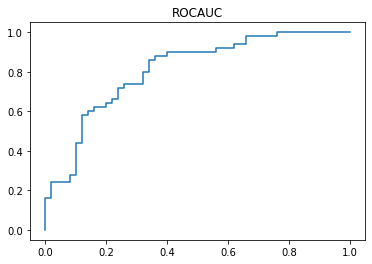

In [45]:
plt.plot(fpr,tpr)
plt.title("ROCAUC")

## 

## Result Analyse

In [129]:
error_dict = {"manipu":np.average(img_scores[:10]),
            "sc_head":np.average(img_scores[10:20]),
            "sc_neck":np.average(img_scores[20:30]),
            "thread_side":np.average(img_scores[30:40]),
            "thread_top":np.average(img_scores[40:])}

error_dict

{'manipu': 0.7388073,
 'sc_head': 0.6638798,
 'sc_neck': 0.73967457,
 'thread_side': 0.61221313,
 'thread_top': 0.55795836}

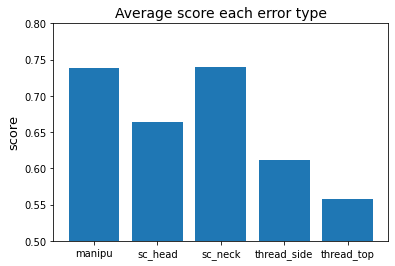

In [142]:
plt.bar(error_dict.keys(),error_dict.values())
plt.ylim([0.5,0.8])
plt.title("Average score each error type",fontsize=14)
plt.ylabel("score",fontsize=13)
plt.savefig("Average score each error type")

path     ../dataset/train/not-good/manipulated_front005...
label                                                    1
Name: 5, dtype: object


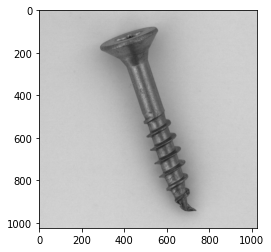

In [121]:
i = 5
print(labels.iloc[i])
check_img = Image.open(val.iloc[i]["path"]).convert("RGB")
plt.imshow(check_img)
#plt.imshow(val_dataset[6][0].numpy().transpose(1,2,0))
plt.savefig("miss_class_manipfront_5")